# ADCP Data Notebook for CAHW 2018

The following is the (brief) work I put together as part of the Cabled Array Hack Week from Feb 21-23, 2018 at the University of Washington.  The overall group goal was to investigate data and anomolies associated with the total eclipse that occured over the cabled array in AUgust of 2017, and provide tools for analysis of the platform and profiler as an instrumentation package.  The platform and the base of the node contain three independent ADCPs, and the ability to retrive and view multiple frequencies and scales of acoustic data in a single format will be useful for investigate temporal variability in pelagic ecology.

My goal in this notebook is to be able to:
1. Request and obtain netcdf ADCP Data from the OOI Data Server
2. Produce Figures of water column echo intensity in identical format to EK60/AZFP echograms
3. Extract a metric to investigate the impact of the eclipse on the diel migration cycle
4. Conversion of EI values to absolute (Sv) acoustic backscatter using additional engineering and metadata requested through the data portal

Input access tokens and complete request for adcp data from the date of the eclipse

In [3]:
username ='OOIAPI-I0UCP16V67ENKZ'
token = '4CUPODF4AL256S'

import requests
import time
subsite = 'RS01SBPS'
node = 'PC01A'
sensor = '05-ADCPTD102'
method = 'streamed'
stream = 'adcp_velocity_beam'
beginDT = '2017-08-21T00:00:00.000Z' #begin of first deployement
# endDT = None
endDT = '2017-08-22T23:59:59.000Z' #begin of first deployement

Send the request based on the platform and sensor information provided above

In [4]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}
r = requests.get(data_request_url, params=params, auth=(username, token))
data = r.json()

The first url in the response is the location on THREDDS where the data is being served. We will get back to using the THREDDS location later.

In [5]:
print(data['allURLs'][0])

https://opendap.oceanobservatories.org/thredds/catalog/ooi/leviner@uw.edu/20180223T050333-RS01SBPS-PC01A-05-ADCPTD102-streamed-adcp_velocity_beam/catalog.html


The second url in the response is the regular APACHE server location for the data.

We will use this second location to programatically check for a status.txt file to be written, containing the text 'request completed'. This indicates that the request is completed and the system has finished writing out the data to this location. This step may take a few minutes.

In [6]:
print(data['allURLs'][1])

https://opendap.oceanobservatories.org/async_results/leviner@uw.edu/20180223T050333-RS01SBPS-PC01A-05-ADCPTD102-streamed-adcp_velocity_beam


We will use this second location to programatically check for a status.txt file to be written, containing the text 'request completed'. This indicates that the request is completed and the system has finished writing out the data to this location. This step may take a few minutes.

In [7]:
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed


In [4]:
import re
import xarray as xr
import pandas as pd
import os

Find all of the netcdf files in the directory

In [33]:
url = data['allURLs'][0]
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)

for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]

Note the slashes:  ['https://opendap.oceanobservatories.org/thredds/dodsC\\ooi/leviner@uw.edu/20180223T050333-RS01SBPS-PC01A-05-ADCPTD102-streamed-adcp_velocity_beam/deployment0004_RS01SBPS-PC01A-05-ADCPTD102-streamed-adcp_velocity_beam_20170821T000000.243324-20170822T235958.558768.nc']
Now corrected:  ['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/leviner@uw.edu/20180223T050333-RS01SBPS-PC01A-05-ADCPTD102-streamed-adcp_velocity_beam/deployment0004_RS01SBPS-PC01A-05-ADCPTD102-streamed-adcp_velocity_beam_20170821T000000.243324-20170822T235958.558768.nc']


Now we'll use xarray to open up the netcdf file

In [ ]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds = ds.chunk({'time': 100})
ds

## Plotting with matplotlib

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date

depth_vec = ds.bin_depths.values[0]

depth_max = max(depth_vec)
depth_min =min(depth_vec)
echo_intb1 = ds.corrected_echo_intensity_beam1.values.transpose()
echo_intb2 = ds.corrected_echo_intensity_beam2.values.transpose()
echo_intb3 = ds.corrected_echo_intensity_beam3.values.transpose()
echo_intb4 = ds.corrected_echo_intensity_beam4.values.transpose()
sz = echo_intb1.shape
print('Size of Dataset (pings,depth): ', sz)

Size of Dataset (pings,depth):  (28, 227989)


In [11]:
depth_idx_start = np.searchsorted(depth_vec, depth_min, side="left")
depth_idx_end = np.searchsorted(depth_vec, depth_max, side="right")
if depth_idx_end>=depth_vec.shape[0]:
    depth_idx_end = depth_vec.shape[0]-1
    
depth_ticks_num = 5
y_ticks_spacing = sz[0]/(depth_ticks_num-1)
y_ticks = np.arange(depth_ticks_num)*y_ticks_spacing
depth_spacing = np.around((depth_max-depth_min)/(depth_ticks_num-1),decimals=1)
depth_label = np.around((np.arange(depth_ticks_num)*depth_spacing)+depth_min,decimals=1)

Can't seem to get the datetime string format right, using the pd.to_datetime, in order to format, but there's gotta be a way to do this right on the numpy datetime

In [12]:
#num_ping_to_plot = 12000
num_ping_to_plot = sz[1]
num_ping_label = 10
x_ticks = np.int32(np.arange(0,num_ping_label)*num_ping_to_plot/num_ping_label)
x_ticks_label = [x.strftime('%H:%M') for x in pd.to_datetime(ds.time.values[x_ticks])]

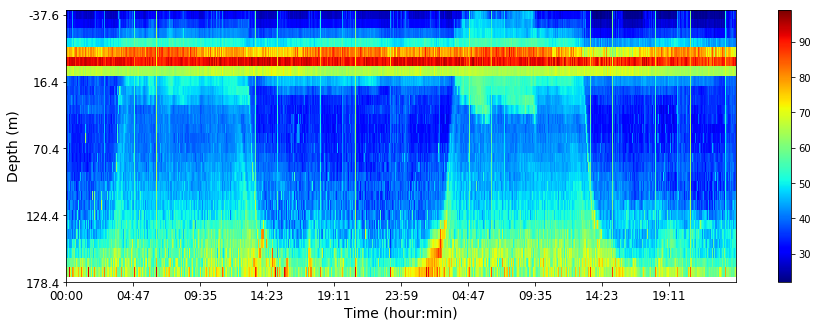

In [13]:
fig = plt.figure(figsize=(15,5))
plt.imshow(echo_intb1[::-1,0:num_ping_to_plot],aspect='auto',vmax=np.ceil(np.amax(echo_intb1)),vmin=np.floor(np.amin(echo_intb1)),cmap='jet')
plt.xticks(x_ticks,x_ticks_label,fontsize=12)
plt.yticks(y_ticks,depth_label,fontsize=12)
plt.xlabel('Time (hour:min)',fontsize=14)
plt.ylabel('Depth (m)',fontsize=14)
plt.colorbar()
plt.show()

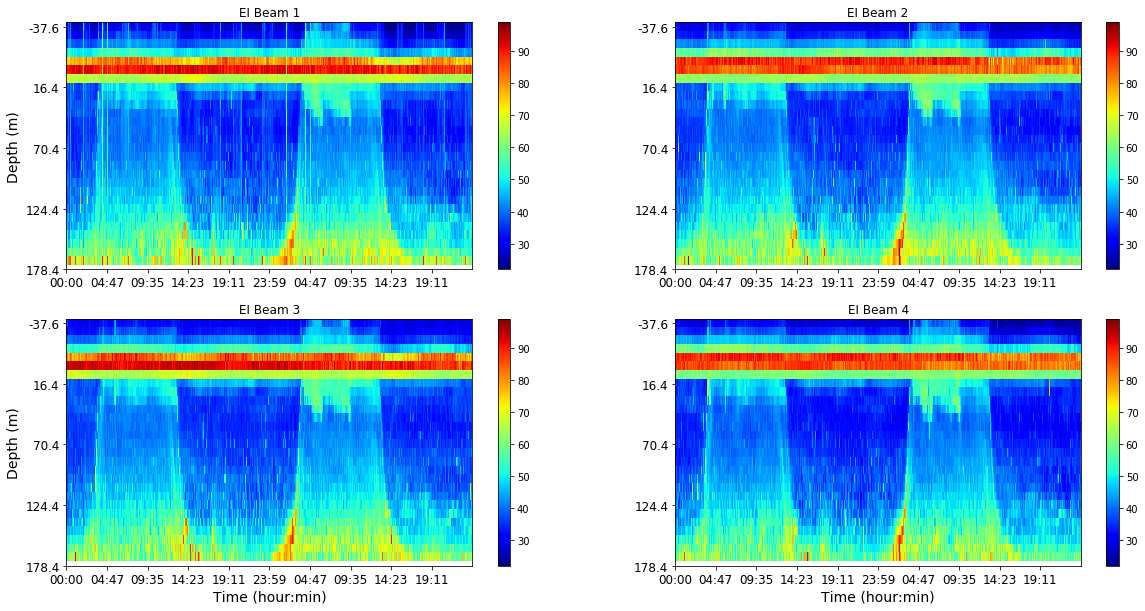

In [14]:
fig = plt.figure(figsize=(20,10))
plt.figure(1)

plt.subplot(221)
plt.imshow(echo_intb1[::-1,0:num_ping_to_plot],aspect='auto',vmax=np.ceil(np.amax(echo_intb1)),vmin=np.floor(np.amin(echo_intb1)),cmap='jet')
plt.xticks(x_ticks,x_ticks_label,fontsize=12)
plt.yticks(y_ticks,depth_label,fontsize=12)
#plt.xlabel('Time (hour:min)',fontsize=14)
plt.ylabel('Depth (m)',fontsize=14)
plt.title('EI Beam 1')
plt.colorbar()

plt.subplot(222)
plt.imshow(echo_intb2[::-1,0:num_ping_to_plot],aspect='auto',vmax=np.ceil(np.amax(echo_intb1)),vmin=np.floor(np.amin(echo_intb1)),cmap='jet')
plt.xticks(x_ticks,x_ticks_label,fontsize=12)
plt.yticks(y_ticks,depth_label,fontsize=12)
#plt.xlabel('Time (hour:min)',fontsize=14)
#plt.ylabel('Depth (m)',fontsize=14)
plt.title('EI Beam 2')
plt.colorbar()


plt.subplot(223)
plt.imshow(echo_intb3[::-1,0:num_ping_to_plot],aspect='auto',vmax=np.ceil(np.amax(echo_intb1)),vmin=np.floor(np.amin(echo_intb1)),cmap='jet')
plt.xticks(x_ticks,x_ticks_label,fontsize=12)
plt.yticks(y_ticks,depth_label,fontsize=12)
plt.xlabel('Time (hour:min)',fontsize=14)
plt.ylabel('Depth (m)',fontsize=14)
plt.title('EI Beam 3')
plt.colorbar()

# logit
plt.subplot(224)
plt.imshow(echo_intb4[::-1,0:num_ping_to_plot],aspect='auto',vmax=np.ceil(np.amax(echo_intb1)),vmin=np.floor(np.amin(echo_intb1)),cmap='jet')
plt.xticks(x_ticks,x_ticks_label,fontsize=12)
plt.yticks(y_ticks,depth_label,fontsize=12)
plt.xlabel('Time (hour:min)',fontsize=14)
#plt.ylabel('Depth (m)',fontsize=14)
plt.title('EI Beam 4')
plt.colorbar()

plt.show()

## Plotting with the built in xarray functions

c:\users\robert\appdata\local\programs\python\python36\lib\site-packages\xarray\plot\utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


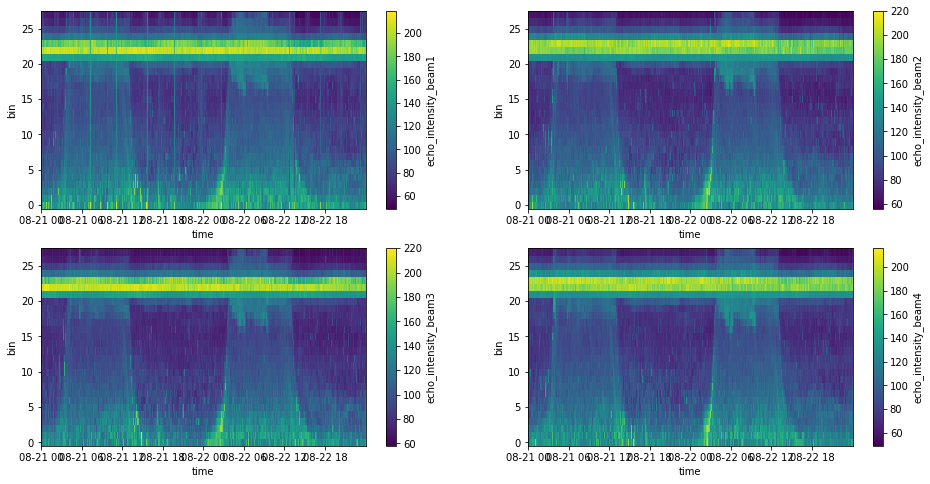

In [15]:
fig,ax = plt.subplots(2,2,figsize=(16,8))
ds['echo_intensity_beam1'].T.plot(ax=ax[0,0])
ds['echo_intensity_beam2'].T.plot(ax=ax[0,1])
ds['echo_intensity_beam3'].T.plot(ax=ax[1,0])
ds['echo_intensity_beam4'].T.plot(ax=ax[1,1])
plt.show()

## Mean-weighted depth
From De Robertis and Wilson, 2011:

$ mwd_{t} = \dfrac{\Sigma_{D} D \times s_{A,D,t}}{\Sigma_{D} s_{A,D,t}}$

Where :

- $D$ is the depth (m)
- s_{A,D,t} is the s_{A} in the depth interval from depth $D$ to $D + 1$

In [16]:
def mean_weighted_depth(ds, echo_variable_name):
    mwd = []
    bd = ds.bin_depths.values
    eb = ds[echo_variable_name].values
    for t in range(eb.shape[0]):
        cur_ping = sum(eb[t,:]*bd[t,:])/sum(eb[t,:])
        mwd.append(cur_ping)
    mwd = pd.DataFrame(mwd,ds.time.values)
    return mwd

In [21]:
echo_variables = ['corrected_echo_intensity_beam1','corrected_echo_intensity_beam2','corrected_echo_intensity_beam3','corrected_echo_intensity_beam4']
eb1 = mean_weighted_depth(ds,echo_variables[0])
eb2 = mean_weighted_depth(ds,echo_variables[1])
eb3 = mean_weighted_depth(ds,echo_variables[2])
eb4 = mean_weighted_depth(ds,echo_variables[3])

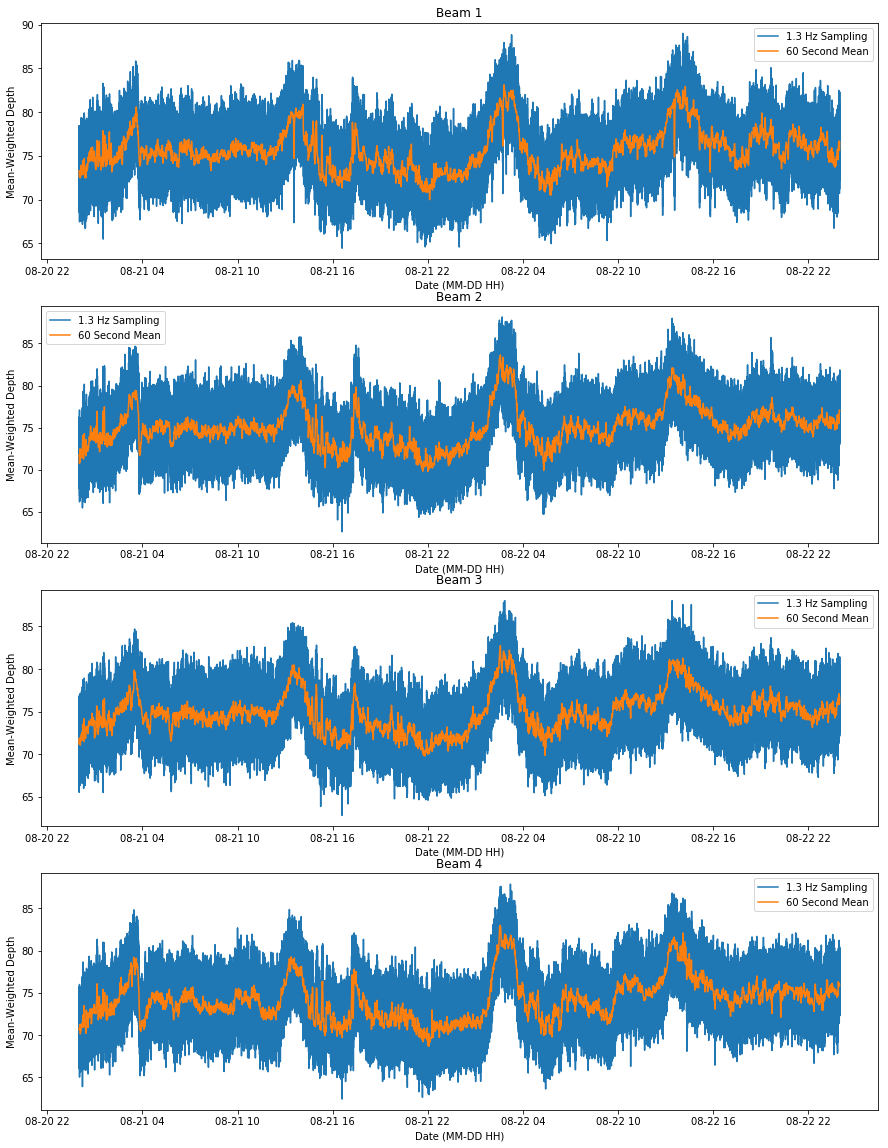

In [53]:
fig = plt.figure(figsize=(15,20))
plt.figure(1)

plt.subplot(411)
plt.plot(eb1)
plt.plot(eb1.resample('60S').mean())
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Mean-Weighted Depth')
plt.title('Beam 1')
plt.legend(['1.3 Hz Sampling', '60 Second Mean'])


plt.subplot(412)
plt.plot(eb2)
plt.plot(eb2.resample('60S').mean())
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Mean-Weighted Depth')
plt.title('Beam 2')
plt.legend(['1.3 Hz Sampling', '60 Second Mean'])


plt.subplot(413)
plt.plot(eb3)
plt.plot(eb3.resample('60S').mean())
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Mean-Weighted Depth')
plt.title('Beam 3')
plt.legend(['1.3 Hz Sampling', '60 Second Mean'])


plt.subplot(414)
plt.plot(eb4)
plt.plot(eb4.resample('60S').mean())
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Mean-Weighted Depth')
plt.title('Beam 4')
plt.legend(['1.3 Hz Sampling', '60 Second Mean'])
plt.show()

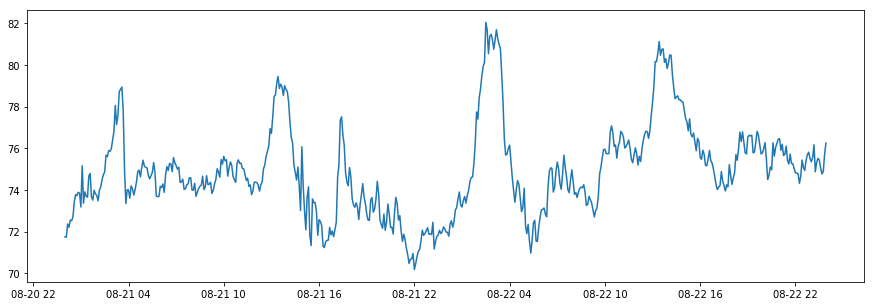

In [58]:
eb_mean = (eb1+eb2+eb3+eb4)/4
fig = plt.figure(figsize=(15,5))
plt.figure(1)
plt.plot(eb_mean.resample('300S').mean())

It is clear that there are a lot of tidal forcings here, not only from changes in sea level height but also caused by the tilt/roll of the platform itself, which changes the range to the surface for each beam.  The next step required would be for correction

# Future products

## Conversion of EI to Sv

### Dienes et al., 1999 (From Jiang et al., 2007)
$ Sv =  C + 10log_{10}((T_{X}+273.16)R^{2}) - L_{DBM} - P_{DBW} + 2\alpha R + K_{c} (E-E_{R})$ 

Where the following are sample (time, range) specific:

- $E$ is the echo intensity
- $E_{r}$ is the reference intensity, equivalent to the lowest value of E measured in the water column during the entire data collection period
- $T_{X}$ is the transducer temperature ($^{\circ}C$)
- $R$ is the range to the scatterer (m)
- $L_{DBW}$ is $10log_{10}($transmit pulse length$)$ in  meters 
- $\alpha$ is the sound absorption coefficient of water ($dB m^{-1}$)
- $P_{DBW}$ is $10log_{10}($transmit power$) $ in Watts

The following are provided by the manufacturer:

- $C$ is an empirical constant 
- $K_{c}$ is the conversion factor for echo intensity ($db count^{-1}$)

Let's look for what variables are included in the science stream as opposed to what we will need to try to dig out fromt he engineering stream.

In [464]:
E = ds.corrected_echo_intensity_beam1.values
Er = np.amin(ds.corrected_echo_intensity_beam1.values)
R = ds.bin_depths.values
Tx = ds.temperature.values/100

22.05

We will need the profiler CTD data from the water column in order to determine the absorption at the scatterer range.  A good option would be to take the average from all fo the profiles for each depth $R$ of scatterers (i.e,. absorption of the water column determined from salinity and temperature between platform depth and range $R$ the last $n$ profiles.

Transmit pulse, transmit power, $C$, and $K_{c}$ all require additional engineering data that it appears does not exists in the feed.  Disucssions with OOI/APL may be required for SN-specific calibratino values.